In [35]:
import os
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
import torch
import torchvision
from torchvision.transforms import v2
from torchvision import tv_tensors

from load_data.custom_dataset import CustomDataset
from load_data.collate import collate_fn
from utilities.plot_boxes import plot_boxes
from utilities.load_boundingbox import load_bbx
from utilities.load_labels import load_label_from_txt_to_df, load_label_from_txt_to_str

# folders

In [2]:
root = 'datasets/wider_face/'
train_img_folder = f"{root}wider_train/WIDER_train/imagesimages/train/"
train_lbl_folder = f"{root}wider_train/WIDER_train/imageslabels/train/"
val_img_folder = f"{root}wider_val/WIDER_val/imagesimages/val/"
val_img_folder = f"{root}wider_val/WIDER_val/imageslabels/val/"

# Prepare label 

In [3]:
img = Image.open(f"{train_img_folder}{os.listdir(train_img_folder)[3]}")

In [4]:
txt_path = f"{train_lbl_folder}{os.listdir(train_lbl_folder)[3]}"

In [5]:
box1 = load_label_from_txt_to_str(txt_path)

In [6]:
box1

['0 0.4267578125 0.359375 0.205078125 0.3854166666666667',
 '0 0.619140625 0.4752604166666667 0.1796875 0.3463541666666667']

In [25]:
def transform_label(label, class_ind):
    output_list = list()
    for l in label:
        temp_list = [1.0]
        C, x, y, w, h = map(float, l.split(" "))
        print(f"Class-{C}, x-{x}, y-{y}, w-{w}, h-{h}")
        temp_list = temp_list + [x, y, w, h] + ([0.0] * len(class_ind))
        temp_list[4 + class_ind.index(C) + 1] = 1.0
        output_list.append(temp_list)
    return output_list     

In [28]:
out = transform_label(box1, [0.0])
print(out)

Class-0.0, x-0.4267578125, y-0.359375, w-0.205078125, h-0.3854166666666667
Class-0.0, x-0.619140625, y-0.4752604166666667, w-0.1796875, h-0.3463541666666667
[[1.0, 0.4267578125, 0.359375, 0.205078125, 0.3854166666666667, 1.0], [1.0, 0.619140625, 0.4752604166666667, 0.1796875, 0.3463541666666667, 1.0]]


In [ ]:
[1.0, 0.5, 0.4, 0.1, 0.6, 1.0, 0.0, 0.0]

In [76]:
def Yolo_format_label(labels, n, anchor):
    yolo_labels = np.zeros((n, n, len(labels[0]) * anchor))

    # Assign the labels to the array based on the structure provided
    anchor_index = np.zeros((n, n))
    
    for i in range(len(labels)):
        label = labels[i]
        p, x, y, w, h, *class_probs = label
    
        # Calculate grid cell indices for x and y values
        cell_x = int(x * n)
        cell_y = int(y * n)
        
        # Fill in the values in the yolo_labels array
        if anchor_index[cell_x, cell_y] + len(label) > yolo_labels.shape[2]:
            print(F"You need more anchor on cell {cell_x}, {cell_y}")
            print(f"anchor_index[cell_x, cell_y] = {anchor_index[cell_x, cell_y]}")
        else:
            yolo_labels[cell_x, cell_y, int(anchor_index[cell_x, cell_y]):
                                        int(anchor_index[cell_x, cell_y]) + len(label)] = label

        # Calculate the anchor index based on object detectability in one cell
        anchor_index[cell_x, cell_y] += len(label)
        #print(anchor_index)
    

    return yolo_labels

In [70]:
out.append([1.0, 0.1, 0.1, 0.2, 0.3, 1.0])

In [77]:
out

[[1.0, 0.4267578125, 0.359375, 0.205078125, 0.3854166666666667, 1.0],
 [1.0, 0.619140625, 0.4752604166666667, 0.1796875, 0.3463541666666667, 1.0],
 [1.0, 0.1, 0.1, 0.2, 0.3, 1.0],
 [1.0, 0.1, 0.1, 0.2, 0.3, 1.0],
 [1.0, 0.1, 0.1, 0.2, 0.3, 1.0]]

In [78]:
label1 = Yolo_format_label(out, 5, 3)

In [68]:
label1.shape

(5, 5, 18)

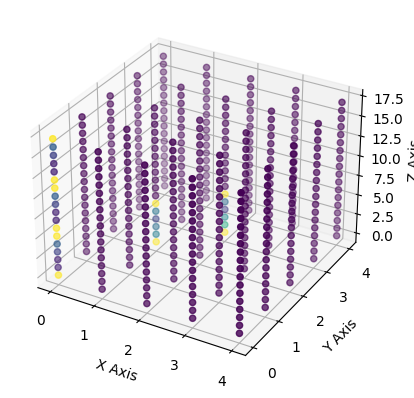

In [79]:
x, y, z = np.meshgrid(np.arange(label1.shape[0]),
                       np.arange(label1.shape[1]),
                       np.arange(label1.shape[2]))

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a 3D surface
ax.scatter(x, y, z, c=label1.flatten(), cmap='viridis')  # You can use different color maps

# Set labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show plot
plt.show()

In [33]:
print(label1)

[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.

# Example labels (replace this with your actual list of labels)
labels = [
    [0.8, 0.2, 0.3, 0.4, 0.5, 0.9, 0.1, 0.0],  # Example label 1
    [0.7, 0.6, 0.4, 0.3, 0.2, 0.2, 0.6, 0.2]   # Example label 2
]

n = 7  # Shape of YOLO grid
anchor = 3  # YOLO anchor (number of objects detectable in one cell)

# Initialize the array with zeros
yolo_labels = np.zeros((n, n, len(labels[0]) * anchor))

# Assign the labels to the array based on the structure provided
for i in range(len(labels)):
    label = labels[i]
    p, x, y, w, h, *class_probs = label

    # Calculate grid cell indices for x and y values
    cell_x = int(x * n)
    cell_y = int(y * n)

    # Calculate the anchor index based on object detectability in one cell
    anchor_index = i * len(label)

    # Fill in the values in the yolo_labels array
    yolo_labels[cell_x, cell_y, anchor_index:anchor_index + len(label)] = label

print(yolo_labels)

In [6]:
df_box1 = load_label_from_txt_to_df(txt_path)

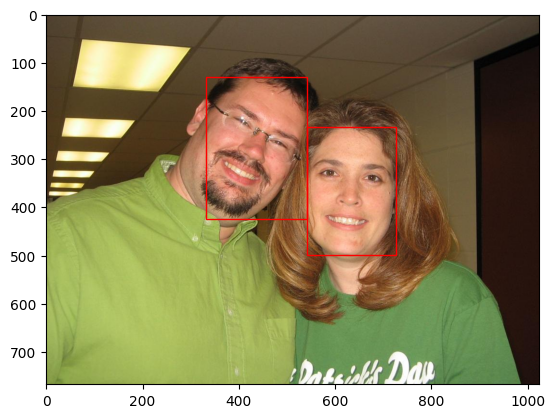

In [7]:
plot_boxes(np.array(img), df_box1)

# Prepare Img np or (tensor)

In [10]:
transforms = v2.Compose([
    v2.Grayscale(1),
    v2.Resize(size=[512, 512])
])
resize_img = transforms(img)

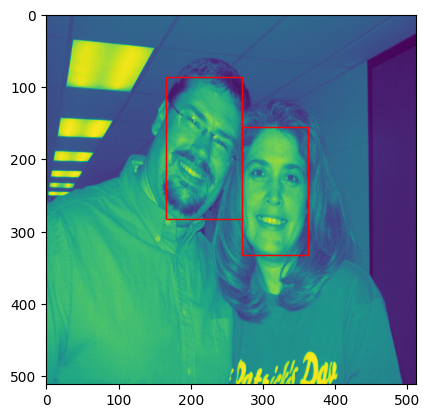

In [15]:
plot_boxes(np.array(resize_img), df_box1)

In [16]:
def get_img_data(folder, transforms):
    output = list()
    for f in tqdm(os.listdir(folder)):
        img = transforms(Image.open(f"{folder}{f}"))
        img = np.array(img)
        img = img[np.newaxis, ...]
        output.append(img)
    return output

In [14]:
new_img.shape

(1, 512, 512)

In [17]:
train_img = get_img_data(train_img_folder, transforms)

100%|███████████████████████████████████████████████████████████████████████████| 12880/12880 [01:58<00:00, 108.64it/s]


# Example

In [ ]:
transforms_to_tensor = v2.Compose([
    v2.Grayscale(1),
    v2.Resize(size=[512, 512]),
    v2.ToTensor()  # Convert PIL image to PyTorch tensor
])

In [ ]:
transforms = v2.Compose([
    v2.Grayscale(1),
    v2.RandomResizedCrop(size=(1024, 1024), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
boxes = tv_tensors.BoundingBoxes(boxes, format="XYWH", canvas_size=(H, W))
img, boxes = transforms(img, boxes)